# Characterize predicted mutations

This notebook processes the ranked mutations in `paper/mutations.tsv` and generates output plots for examining mutational enrichment.

In [1]:
# imports
library(data.table)
library(tidyverse)
library(testit)

── Attaching packages ───────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [2]:
# Set graphics
options(repr.plot.width=10, repr.plot.height=10)
output_plot_dir <- 'paper/mutation_scoring/'
plot_dpi = 300

In [3]:
# Read input data
res_mutations <- fread('paper/mutations.tsv')

In [4]:
# Helper functions
strpart <- function(x, split, n, fixed=FALSE) {
    sapply(strsplit(as.character(x),split,fixed=fixed),'[',n)
}

matrix_to_long_df <- function(matrix) {
    rn <- rownames(matrix)
    cn <- colnames(matrix)
    df <- as.data.frame(matrix)
    colnames(df) <- cn
    df$rownames <- rn
    pivot_longer(df, !rownames, names_to = "colnames")
}

## Get summary of mutations at the top of the list

In [5]:
get_mutation_summary <- function(mutations, n_mutations = NULL, return_matrix = TRUE) {
    aa_chars = sort(c('G','A','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T'))
    
    if (!is.null(n_mutations)) {
        mutations[1:n_mutations,] %>% pull('mutation') -> mutation_strings
    } else {
        mutations %>% pull('mutation') -> mutation_strings
    }
    
    # Extract mutation information
    gene <- strpart(mutation_strings, ':', 1)
    aa_change <- strpart(mutation_strings, ':', 2)
    aa_from <- substr(aa_change,1,1)
    position <- substr(aa_change,2,nchar(aa_change)-1)
    aa_to <- substr(aa_change,nchar(aa_change),nchar(aa_change))
    mutation_data_parse <- data.frame(
        gene,
        aa_from,
        position,
        aa_to
    )
    mutation_data_parse %>% 
        filter(aa_from %in% aa_chars) %>%
        filter(aa_to %in% aa_chars) -> mutation_data_parse
    
    # Count mutations
    mutation_data_parse[,c('aa_from','aa_to')] %>% 
        group_by(aa_from, aa_to) %>% summarise(n=n(), .groups="drop") -> summarized_counts
    
    # pivot wider
    summarized_counts %>% pivot_wider(
        id_cols = c(aa_from, aa_to),
        names_from = aa_to,
        values_from = n,
        values_fill=0
    ) -> mutation_counts_actual
    
    if (return_matrix) {
            # Turn to matrix
        rn <- mutation_counts_actual$aa_from
        cn <- colnames(mutation_counts_actual)
        mutation_counts_actual <- (as.matrix(mutation_counts_actual[,-1]))
        rownames(mutation_counts_actual) <- rn
        colnames(mutation_counts_actual) <- cn[-1]

        # Find missing cols and rows
        missing_cols <- setdiff(aa_chars, colnames(mutation_counts_actual))
        missing_rows <- setdiff(aa_chars, rownames(mutation_counts_actual))

        # Add missing cols
        original_cn <- colnames(mutation_counts_actual)
        mutation_counts_actual <- cbind(mutation_counts_actual, 
                                        matrix(0, nrow(mutation_counts_actual), 
                                               length(missing_cols)))
        colnames(mutation_counts_actual) <- c(original_cn, missing_cols)
        # Add missing rows
        original_rn <- rownames(mutation_counts_actual)
        mutation_counts_actual <- rbind(mutation_counts_actual,
                                        matrix(0, length(missing_rows),
                                              ncol(mutation_counts_actual)))
        rownames(mutation_counts_actual) <- c(original_rn, missing_rows)

        # Put in order
        mutation_counts_actual <- mutation_counts_actual[aa_chars,aa_chars]
        
        # Rows -- from
        # Cols -- to
        mutation_counts_actual <- t(mutation_counts_actual)

        return(mutation_counts_actual)
    } else {
        return(summarized_counts)
    }

}

In [6]:
# Mutation type occurences in top 1000 entries
n_mutations <- 1000

In [7]:
# For confirming orientation of output
get_mutation_summary(res_mutations, n_mutations = n_mutations, return_matrix=FALSE) %>% 
    filter(aa_from == 'I' & aa_to == 'T')

aa_from,aa_to,n
<chr>,<chr>,<int>
I,T,6


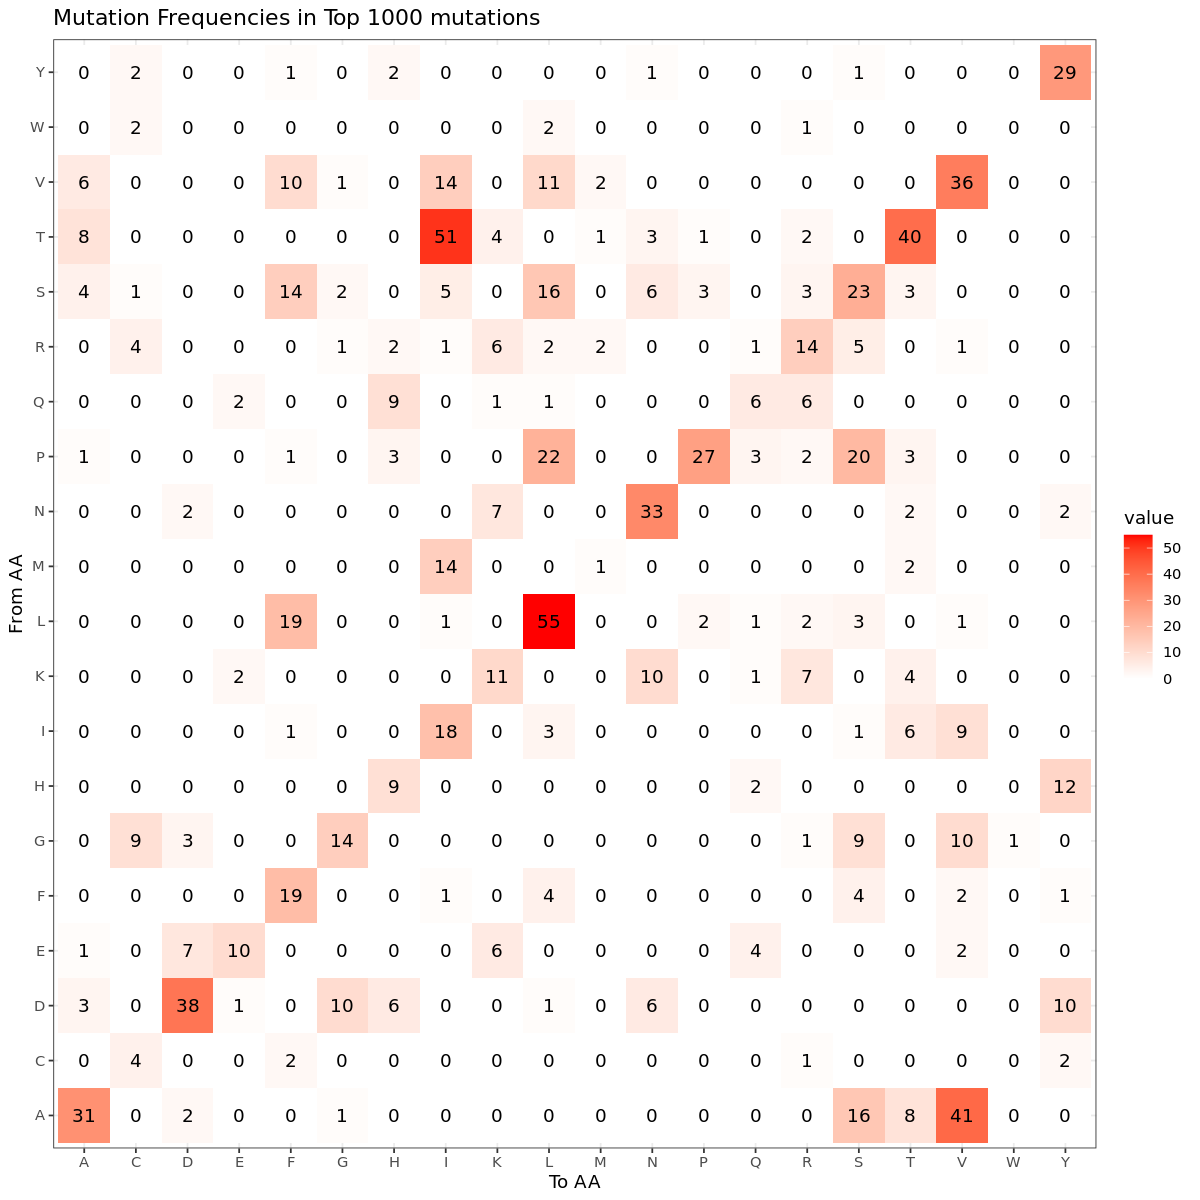

In [8]:
matrix_to_long_df(get_mutation_summary(res_mutations, n_mutations = n_mutations)) %>% 
    ggplot(aes(x=rownames, y=colnames, fill=value)) + 
    geom_tile() +
    theme_bw() +
    scale_fill_gradient(low = "white", high = "red") +
    geom_text(aes(label=value)) +
    ggtitle(paste0('Mutation Frequencies in Top ', n_mutations, ' mutations')) +
    scale_x_discrete(name='To AA') +
    scale_y_discrete(name='From AA') -> plot_aa_frequencies

plot_aa_frequencies

In [9]:
ggsave(paste0(output_plot_dir, 'top_substitutions.png'), width=10, height=10, dpi = plot_dpi)

## Test for enrichment of particular mutations

In [10]:
test_mutation_enrichment <- function(res_mutations, n_mutations=1000, symmetric = TRUE) {
    aa_chars = sort(c('G','A','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T'))
    
    top_mut <- get_mutation_summary(res_mutations, n_mutations)
    universe_mut <- get_mutation_summary(res_mutations, NULL)
    
    pvals <- matrix(0, length(aa_chars), length(aa_chars))
    rownames(pvals) <- colnames(pvals) <- aa_chars
    
    top_total <- sum(top_mut)
    universe_total <- sum(universe_mut)
    
    universe_rate <- universe_mut / universe_total

    for (from_aa in aa_chars) {
        for (to_aa in aa_chars) {
            if (from_aa == to_aa) {
                # Do not test synonymous
                pvals[from_aa, to_aa] <- NA
            } else {
                if (symmetric) {
                    this_mutation_count = top_mut[from_aa, to_aa] + top_mut[to_aa, from_aa] # observed count
                    this_mutation_global_prob = universe_rate[from_aa, to_aa] + universe_rate[to_aa, from_aa] #expected_rate
                } else {
                    this_mutation_count = top_mut[from_aa, to_aa] # observed count
                    this_mutation_global_prob = universe_rate[from_aa, to_aa] # excpected rate
                }
                pvals[from_aa, to_aa] <- dbinom(this_mutation_count, top_total, this_mutation_global_prob)
            }
        }
    }
    
    pvals    
}

In [11]:
# Confirm symmetric output when symmetric comparison
assert(isSymmetric(test_mutation_enrichment(res_mutations, 100, symmetric=TRUE)))

In [12]:
# Look for maximal mutational enrichment while scanning for number of genes considered
summary_fn_min <- function(x) {min(x, na.rm = TRUE)}
summary_fn_mean <- function(x) {mean(x, na.rm = TRUE)}

test_mutation_enrichment_serial <- function(res_mutations, n_start=1, n_end=1000, step=1, symmetric=TRUE, summary_fn=summary_fn_min) {
    xs <- seq(n_start, n_end, step)
    ys <- unlist(lapply(xs, function(x) {
        summary_fn(test_mutation_enrichment(res_mutations,n=x, symmetric=symmetric))
    }))
    most_sign_pval <- data.frame(n=xs, most_sign_pval= ys)
    most_sign_pval
}

In [13]:
# Look both with synonymous and non-synonymour changes considered
# Get mean and maximal p-value for each
n_end <- 3000

most_sign_pval_sym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10, symmetric = TRUE, summary_fn=summary_fn_min)
most_sign_pval_sym$type <- 'most'
most_sign_pval_sym$sym <- 'synonymous'

most_sign_pval_nonsym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = FALSE, summary_fn=summary_fn_min)
most_sign_pval_nonsym$type <- 'most'
most_sign_pval_nonsym$sym <- 'non-synonymous'

mean_sign_pval_sym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = TRUE, summary_fn=summary_fn_mean)
mean_sign_pval_sym$type <- 'mean'
mean_sign_pval_sym$sym <- 'synonymous'

mean_sign_pval_nonsym <- test_mutation_enrichment_serial(res_mutations, n_end=n_end, step=10,symmetric = FALSE, summary_fn=summary_fn_mean)
mean_sign_pval_nonsym$type <- 'mean'
mean_sign_pval_nonsym$sym <- 'non-synonymous'

plot_data <- rbind(most_sign_pval_sym, most_sign_pval_nonsym, mean_sign_pval_sym, mean_sign_pval_nonsym)

In [14]:
# multiple testing corrected p-value for all tests except diagonal
# we can be less stringent in the synonymous case
pval_cutoff <- 0.05 / (20*20-20)

In [15]:
dim(res_mutations)

[1] 6611   11

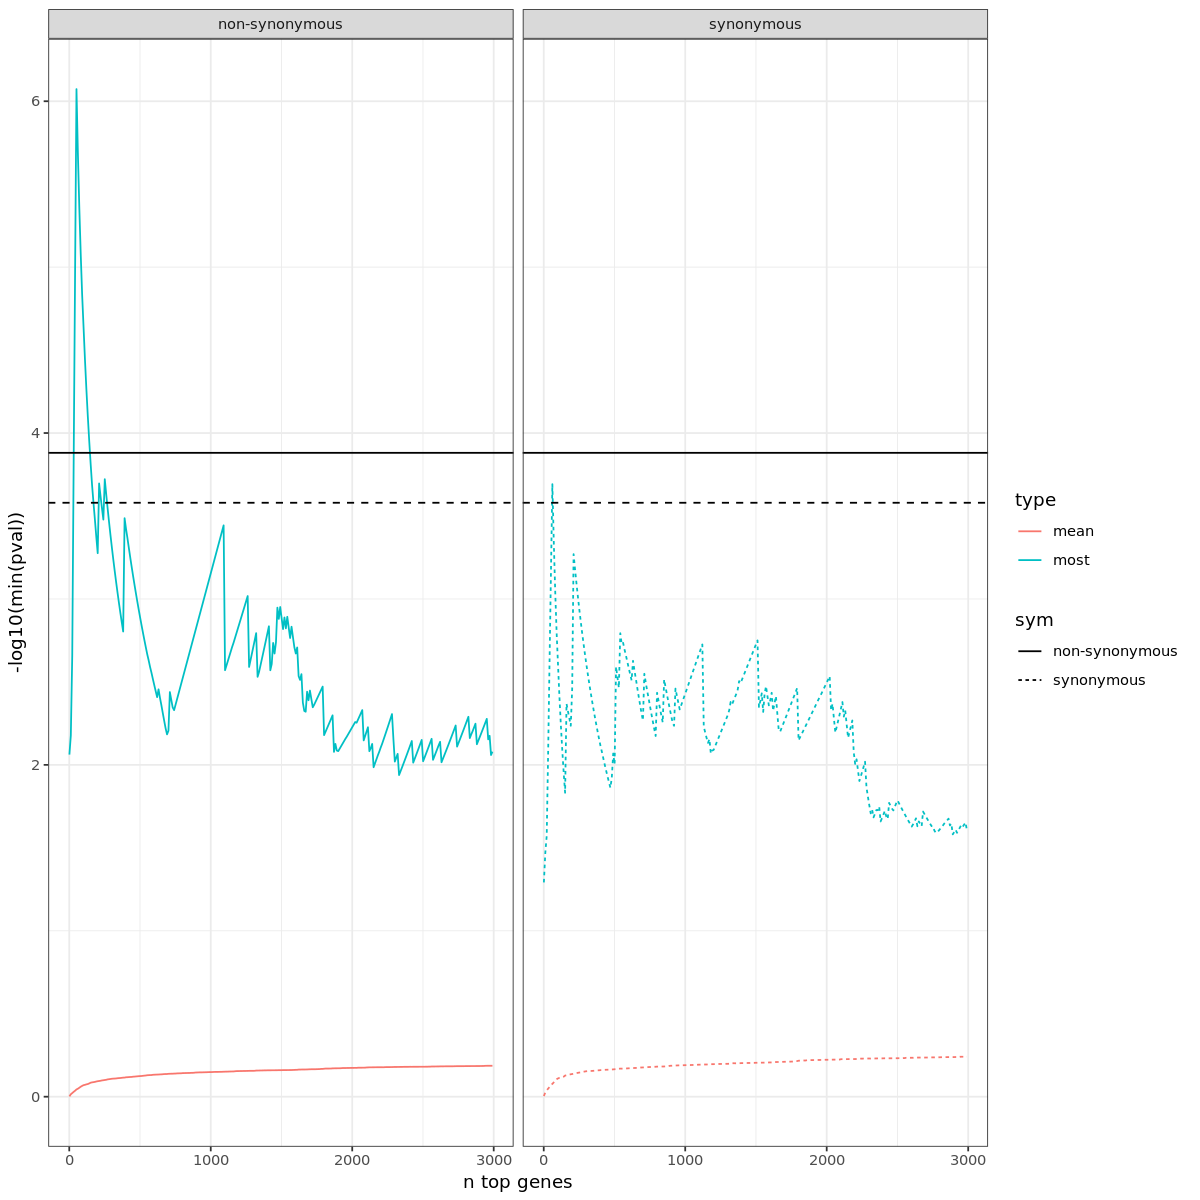

In [16]:
ggplot(plot_data, aes(x=n, y=-log10(most_sign_pval), color=type, linetype=sym)) + 
    geom_line() +
    geom_hline(yintercept = -log10(pval_cutoff)) + 
    geom_hline(yintercept = -log10(pval_cutoff*2), linetype=2) +
    facet_wrap(~sym) +
    theme_bw() + scale_x_continuous(name="n top genes") + 
    scale_y_continuous(name="-log10(min(pval))") -> plot_pval_vs_top_genes

plot_pval_vs_top_genes

In [17]:
ggsave(paste0(output_plot_dir, 'pvals_vs_top_genes.png'), width=15, height=10, dpi = plot_dpi)

In [18]:
test_individual_mutation_enrichment_serial <- function(res_mutations, n_start=1, n_end=1000, step=1, symmetric=TRUE) {
    ns <- seq(n_start, n_end, step)
    info <- do.call(rbind, lapply(ns, function(x) {
        df.tmp <- matrix_to_long_df(test_mutation_enrichment(res_mutations,n=x,symmetric=symmetric))
        df.tmp$n <- x
        df.tmp$aa_change = paste0(df.tmp$rownames,'->', df.tmp$colnames)
        df.tmp$rownames = NULL
        df.tmp$colnames = NULL
        df.tmp
    }))
    info
}

In [19]:
info <- test_individual_mutation_enrichment_serial(res_mutations,1,1000, symmetric=FALSE)

Warning message:
“Removed 20000 row(s) containing missing values (geom_path).”


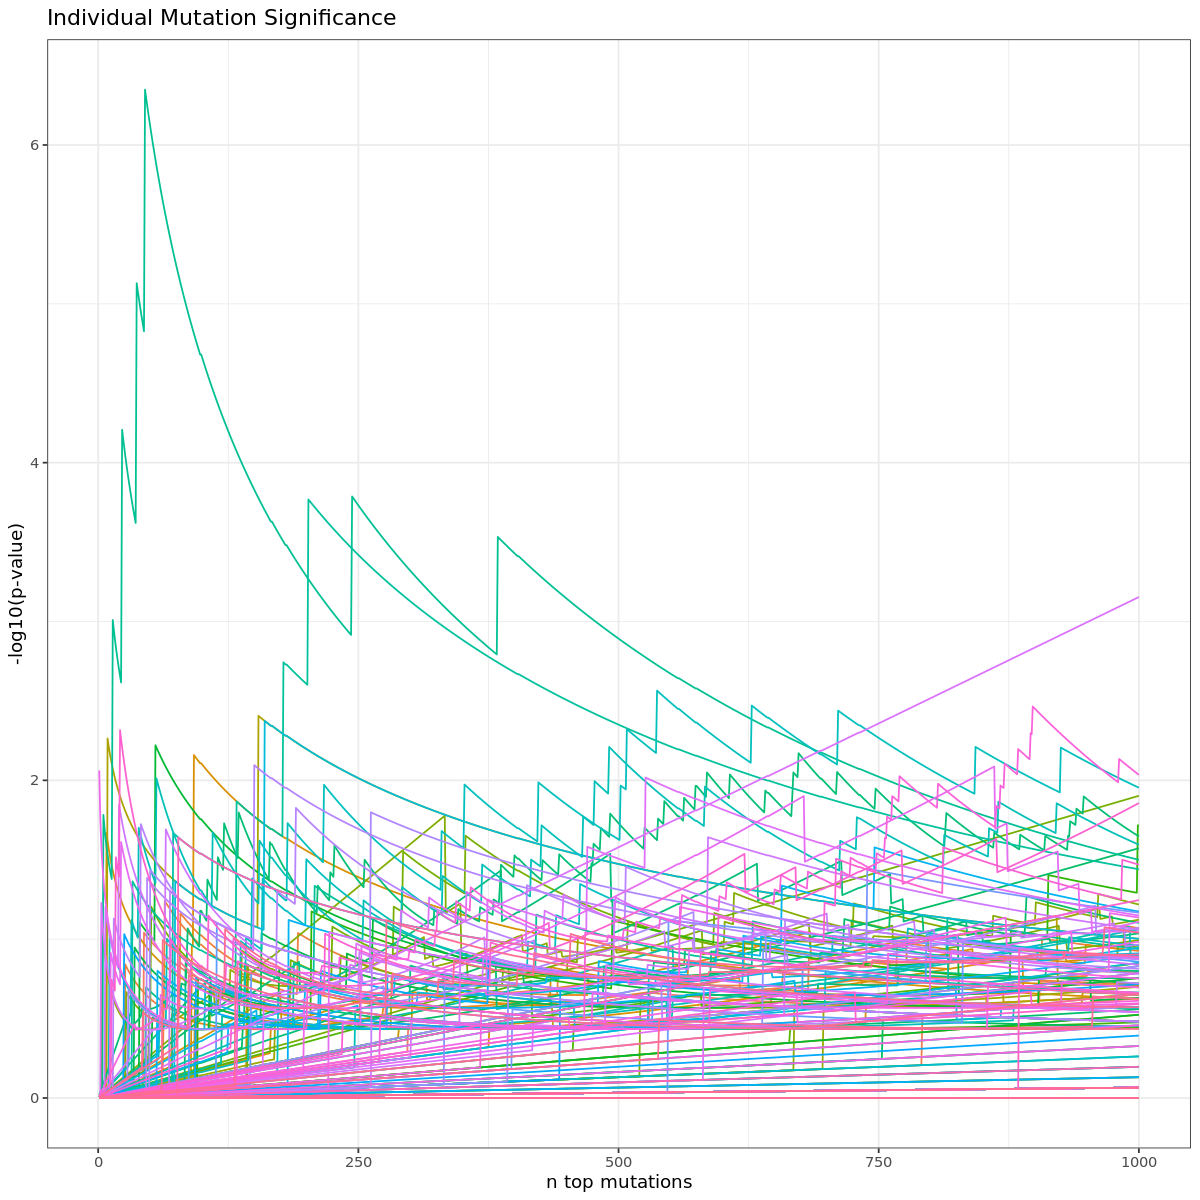

In [20]:
info %>%
    ggplot(aes(x=n,y=-log10(value), color = aa_change)) + 
    geom_line() + 
    theme_bw() + 
    ggtitle('Individual Mutation Significance') +
    theme(legend.position='none') + 
    scale_x_continuous(name='n top mutations') + 
    scale_y_continuous(name='-log10(p-value)') -> plot_individual_mutation_significance

plot_individual_mutation_significance

In [21]:
ggsave(paste0(output_plot_dir,'plot_individual_mutation_significance.png'), width=10, height=10, dpi = plot_dpi)

Warning message:
“Removed 20000 row(s) containing missing values (geom_path).”


In [22]:
info %>% filter(!is.na(value)) %>% 
    group_by(aa_change) %>% 
    summarise(min_pval = min(value)) %>% 
    arrange(min_pval) %>% 
    filter(min_pval < pval_cutoff)

aa_change,min_pval
<chr>,<dbl>
K->N,4.484541e-07


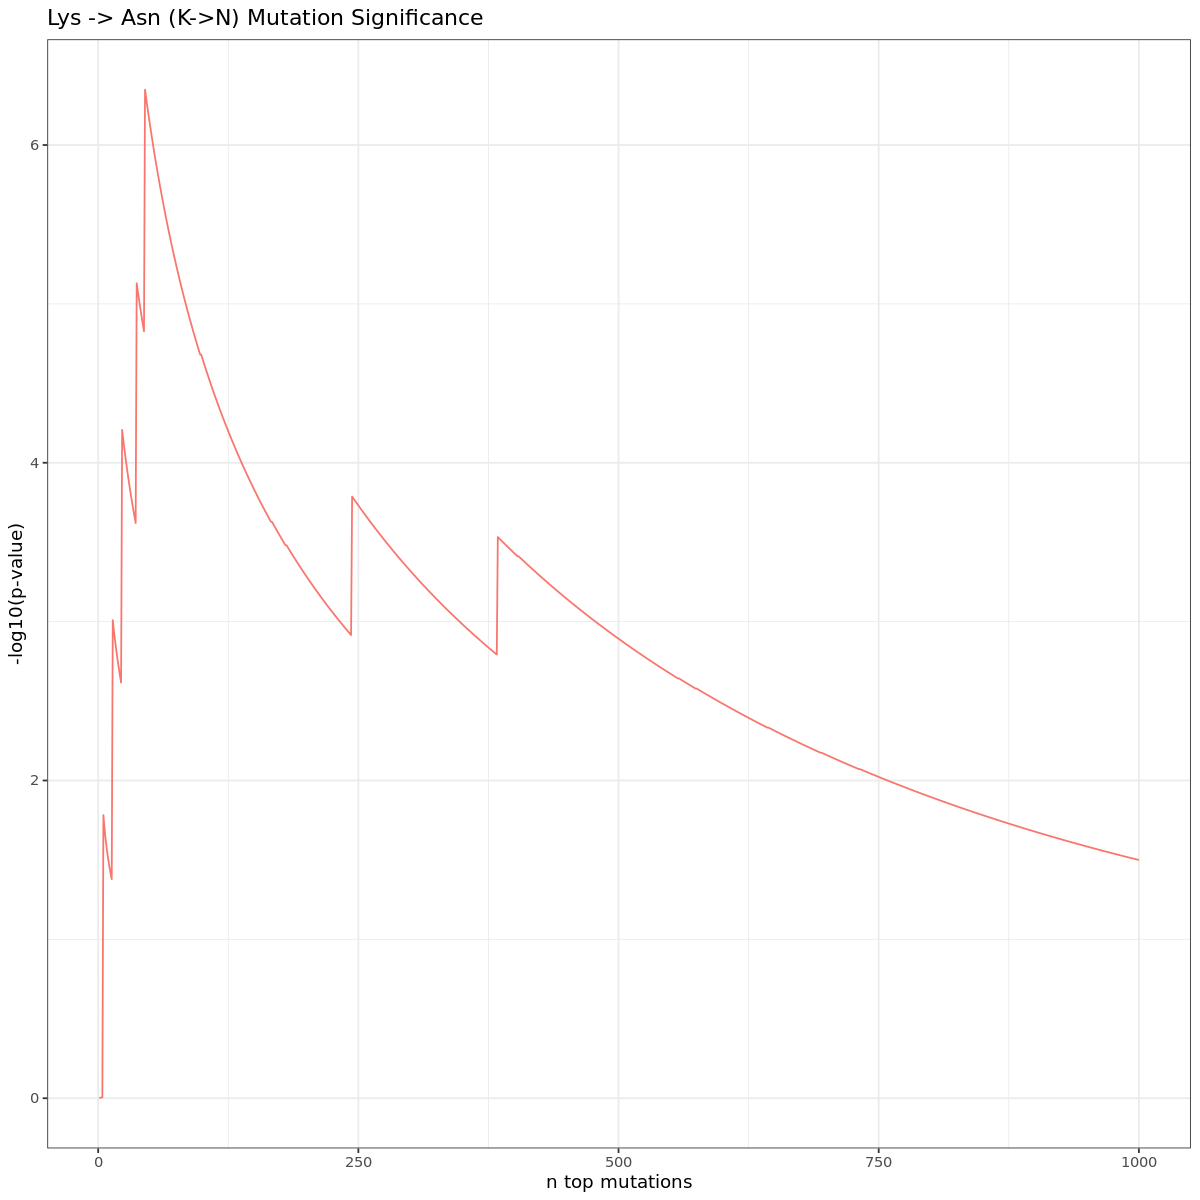

In [23]:
info %>% filter(!is.na(value)) %>% 
    filter(aa_change == 'K->N') %>%
    ggplot(aes(x=n,y=-log10(value), color = aa_change)) + 
    geom_line() + 
    theme_bw() + 
    ggtitle('Lys -> Asn (K->N) Mutation Significance') +
    theme(legend.position='none') + 
    scale_x_continuous(name='n top mutations') + 
    scale_y_continuous(name='-log10(p-value)') -> plot_n_to_k_mutation_significance

plot_n_to_k_mutation_significance

In [24]:
ggsave(paste0(output_plot_dir,'plot_k_to_n_mutation_significance.png'), width=10, height=10, dpi = plot_dpi)